# Grover's Algorithm
- Practicing grover's algorithm for an *n-qubit* search problem 
- We know that the sign flip oracle is $U_f$ and the diffuser is $U_d$.
- Let us try to build a basic n-qubit grover search with a randomized winning state
- Note, that although this is a trivial problem but making it by hand helps to practice the concepts
- Let us start!

In [2]:
from qiskit import *
from qiskit.quantum_info import Operator
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
from qiskit.providers.ibmq import IBMQ

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q-education')

In [3]:
sim = BasicAer.get_backend('qasm_simulator')
sv_sim = BasicAer.get_backend('statevector_simulator')

### 1. Starting out with creating a random winning state 
- We shall create a function which - 
    - Takes in an input bit size $n$
    - Takes in how many winning states $w$ we need to generate
    - Returns the randomly chosen winning states and the complete list 


In [95]:
def get_winners(n, winners):
    assert(winners <= 2**n), "Number of winners must be less than 2**{}".format(n)

    choices = np.random.choice(2**n, winners)
    res = [0 for i in range(2**n)]

    for k in choices:
        res[k] = 1
    return {"winners": list(choices), "list": res}

In [96]:
state = get_winners(3, 1)
state

{'winners': [1], 'list': [0, 1, 0, 0, 0, 0, 0, 0]}

### 2. Initialization of Grover circuit
- Given the number of bits and number of winning states, we build our -
    - Initial equal superposition circuit 
    - Initia oracle $U_f$ for the phase flip on the target states / winning states - 
 $$U_f = I - 2|w\rangle \langle w|$$

In [79]:
def get_oracle(n, winners):
    matrix = np.eye(2**n)

    # make the Uf oracle matrix
    for i in winners:
        try:
            matrix[i][i] = -1
        except:
            print("Invalid winner states")

    # construct the operator
    op = Operator(data=matrix).to_instruction()
    op.name = " " + str(n) + '-qubit $U_f$'
    # construct the quantum circuit
    qc = QuantumCircuit(n)
    qc = qc.compose(op, qubits=range(n))
    return qc

In [80]:
o = get_oracle(3, state['winners'])

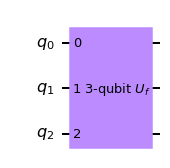

In [81]:
o.draw('mpl')

### 3. Making the diffuser
- The diffuser circuit is the next most important thing in the circuit generation 
- We make the diffuser circuit using the following identity - 
$$U_d = 2|s \rangle \langle s| - I$$
- In the above equation, $|s\rangle$ is the equal superposition state of the circuit

In [139]:
def get_diffuser(n):
    # only the size of the circuit is required to make
    # |s> state

    h = (1/np.sqrt(2))*np.array([[1, 1],
                                 [1, -1]])
    hn = h
    # do tensor n-1 times
    for i in range(n-1):
        hn = np.kron(hn, h)

    # built the hadamard circuit
    # first column is the equal superposition state or just the first row as transpose is equal
    s_state = np.array([hn[0]])

    # build diffuser
    diffuser = 2 * (s_state.transpose() @ s_state) - np.eye(2**n)

    op = Operator(data=diffuser).to_instruction()
    op.name = " " + str(n)+'-qubit $U_d$'
    qc = QuantumCircuit(n)
    qc = qc.compose(op, qubits=range(n))

    return qc

2 qubit hadamard transform
[[ 0.5  0.5  0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5 -0.5  0.5]]
2 qubit diffuser :
 [[-0.5  0.5  0.5  0.5]
 [ 0.5 -0.5  0.5  0.5]
 [ 0.5  0.5 -0.5  0.5]
 [ 0.5  0.5  0.5 -0.5]]


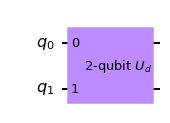

In [83]:
get_diffuser(2).draw('mpl')

# Making final algorithm

- Get a random winner state 

In [97]:
state = get_winners(4, 1)
state

{'winners': [5], 'list': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

- Get the $U_f$ oracle for the Grover iteration 

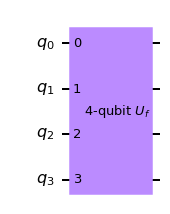

In [98]:
uf = get_oracle(4, state['winners'])
uf.draw('mpl')

- Get the $U_d$ oracle for diffusion

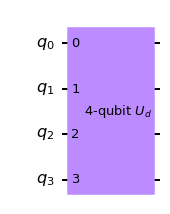

In [140]:
ud = get_diffuser(4)
ud.draw('mpl')

- Searching the list for the winner state


In [101]:
search_list = state['list']
print("List :", search_list)
print("List size :", len(search_list))

List : [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
List size : 16


In [112]:
n = len(search_list)
iters = int(np.ceil(np.sqrt(n)))
print("Iterations required by Grover's :", iters)

Iterations required by Grover's : 4


- Means, 4 Grover circuits are to be appended to our initial equal superposition state 
- Let us make our final circuit


In [128]:
def grover_circuit(num_qubits, Uf, Ud, iters, show=False):
    # make the grover circuit with the Uf and Ud oracle
    # repeated iters number of times in the quatum circuit

    qc = QuantumCircuit(num_qubits)

    qc.h(range(num_qubits))
    qc.barrier()

    qubits = range(num_qubits)
    for i in range(iters):
        qc = qc.compose(Uf, qubits=qubits)
        qc = qc.compose(Ud, qubits=qubits)
        qc.barrier()

    qc.measure_all()

    if show:
        display(qc.draw('mpl', scale=1.5))
    # now, probability of finding the winner state must
    # be very high when we measure the circuit finally
    return qc

In [135]:
circ = grover_circuit(4, uf, ud, 4)

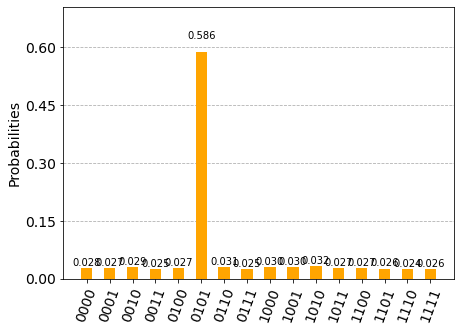

In [136]:
res = execute(circ, backend=sim, shots=2**12).result()
counts = res.get_counts()
plot_histogram(counts, color=['orange'])

## Running a simulation as the iterations increase
- Let us choose a 6-qubit circuit with a search capability of 64 items
- Let us pick a winner and simulate our circuit as the iterations increase from 1 -> 8
- We shall see that Grover's algorithm converges to the winning state in $O(\sqrt{N})$ iterations

In [137]:
def get_grover_things(qubits, winners):
    # 1. get the state
    state = get_winners(qubits, winners)
    # 2. get the winner
    winning = state['winners']
    # 3. uf oracle
    uf = get_oracle(qubits, winning)
    # 4. ud diffuser
    ud = get_diffuser(qubits)

    return (winning, uf, ud)

In [154]:
winner, uf, ud = get_grover_things(qubits=5, winners=1)
print("Winner state : ",winner)
print(bin(winner[0])[2:])

Winner state :  [18]
10010


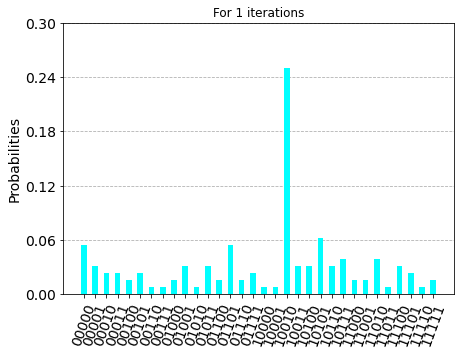

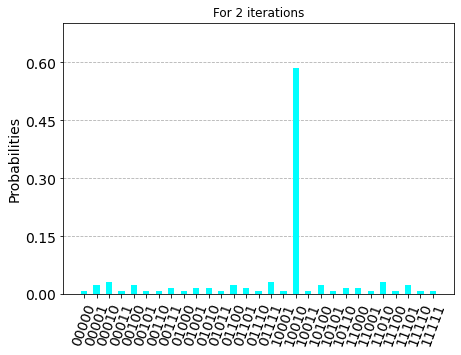

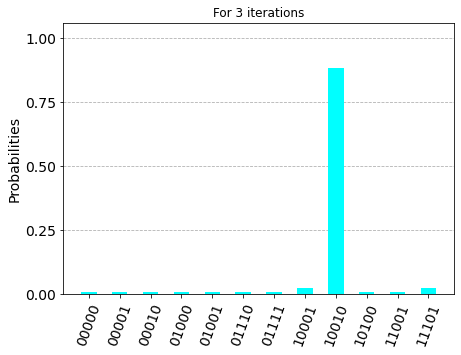

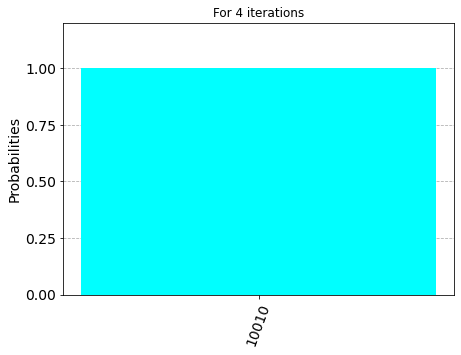

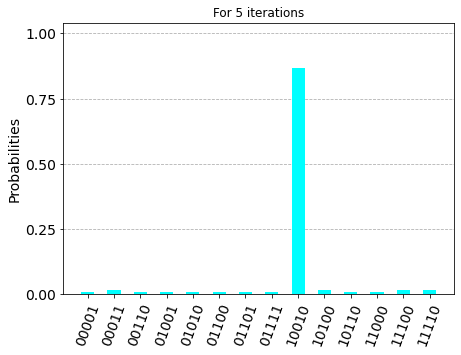

In [159]:
for it in range(1, 6):
    grover = grover_circuit(5, uf, ud, it)
    res = execute(grover, backend=sim, shots=2**7).result()
    counts = res.get_counts()
    display(plot_histogram(counts, bar_labels = False, color=['cyan'],title = 'For {} iterations'.format(it)))

## This is nice :) Almost perfect query results in 4 iterations
- Next steps : to work out manual circuit decomposition for the $U_f$ and the $U_d$ oracles inside a Grover iteration
- NOTE: $U_f$ shall be easy to break down in single-level and two-level gates


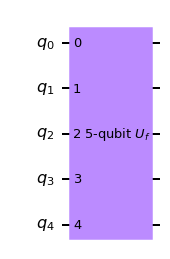

In [162]:
# current state of the grover oracle 
uf = get_oracle(5,winner)
uf.draw('mpl')

Count of operations :  OrderedDict([('cx', 33), ('rz', 30), ('u2', 8), ('u3', 1)])


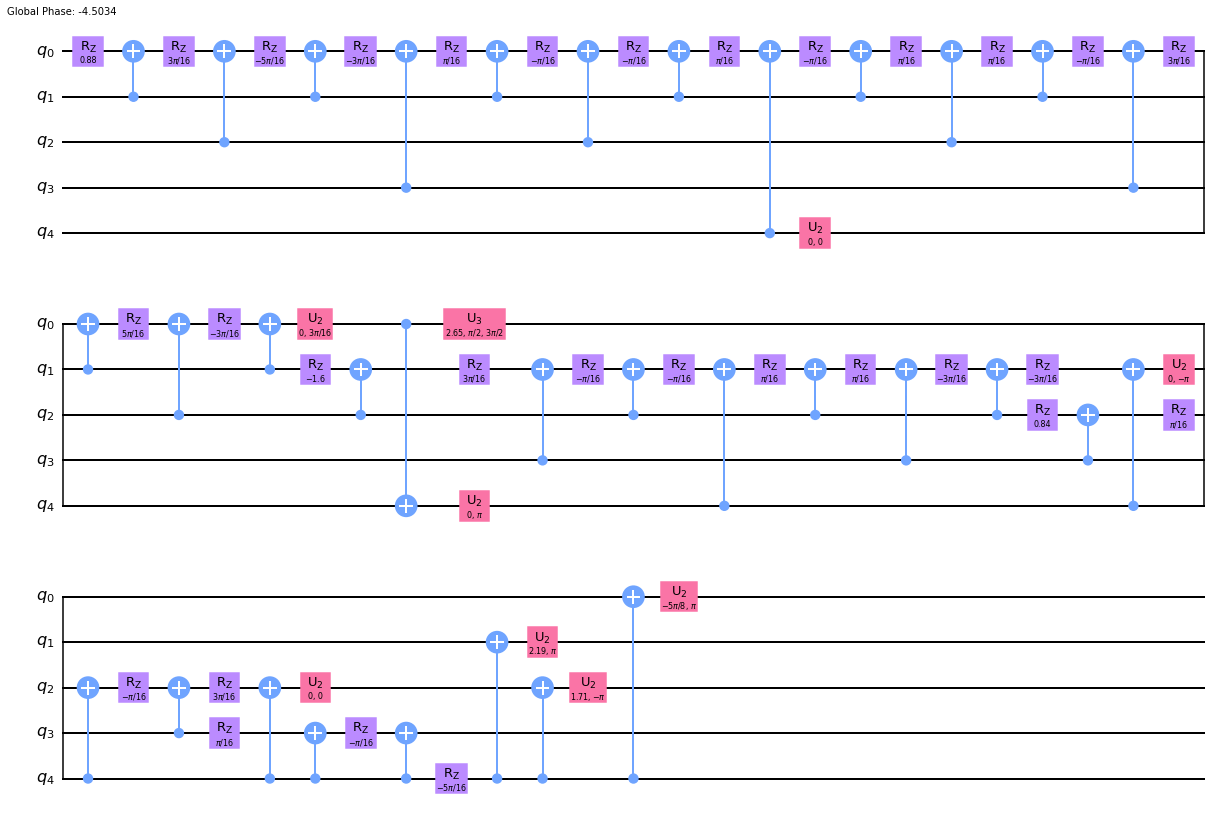

In [166]:
tr = transpile(uf,backend = sim, optimization_level=3) 
print("Count of operations : ",tr.count_ops())
tr.draw('mpl')

In [167]:
print("Current count is :",sum(list(tr.count_ops().values())))

Current count is : 72


- to-do better...